In [1]:
import matplotlib.pyplot as plt
import tensorflow as tf
import numpy as np
from sklearn.metrics import confusion_matrix
import math
%matplotlib inline

In [7]:
from tensorflow.examples.tutorials.mnist import input_data
data = input_data.read_data_sets('data/MNIST/', one_hot=True)

Extracting data/MNIST/train-images-idx3-ubyte.gz
Extracting data/MNIST/train-labels-idx1-ubyte.gz
Extracting data/MNIST/t10k-images-idx3-ubyte.gz
Extracting data/MNIST/t10k-labels-idx1-ubyte.gz


In [8]:
print("Size of:")
print("- Training-set:\t\t{}".format(len(data.train.labels)))
print("- Test-set:\t\t{}".format(len(data.test.labels)))
print("- Validation-set:\t{}".format(len(data.validation.labels)))

Size of:
- Training-set:		55000
- Test-set:		10000
- Validation-set:	5000


In [9]:
#Data Dimensions

# MNIST images are 28 pixels in each dimension.
img_size = 28

# Images are stored in one-dimensional arrays of this length.
img_size_flat = img_size * img_size

# Tuple with height and width of images used to reshape arrays.
img_shape = (img_size, img_size)

# Number of colour channels for the images: 1 channel for gray-scale.
num_channels = 1

# Number of classes, one class for each of 10 digits.
num_classes = 10

In [10]:
data.test.cls = np.argmax(data.test.labels, axis=1)

In [11]:
#ploting images

def plot_images(images, cls_true, cls_pred=None):
    assert len(images) == len(cls_true) == 9
    
    # Create figure with 3x3 sub-plots.
    fig, axes = plt.subplots(3, 3)
    fig.subplots_adjust(hspace=0.3, wspace=0.3)

    for i, ax in enumerate(axes.flat):
        # Plot image.
        ax.imshow(images[i].reshape(img_shape), cmap='binary')

        # Show true and predicted classes.
        if cls_pred is None:
            xlabel = "True: {0}".format(cls_true[i])
        else:
            xlabel = "True: {0}, Pred: {1}".format(cls_true[i], cls_pred[i])

        # Show the classes as the label on the x-axis.
        ax.set_xlabel(xlabel)
        
        # Remove ticks from the plot.
        ax.set_xticks([])
        ax.set_yticks([])
    
    # Ensure the plot is shown correctly with multiple plots
    # in a single Notebook cell.
    plt.show()

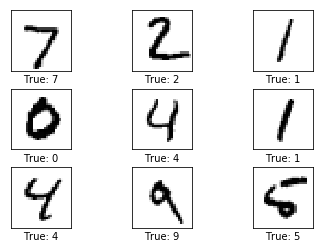

In [12]:
# Get the first images from the test-set.
images = data.test.images[0:9]

# Get the true classes for those images.
cls_true = data.test.cls[0:9]

# Plot the images and labels using our helper-function above.
plot_images(images=images, cls_true=cls_true)

In [14]:
#PlaceHolder Variables
x = tf.placeholder(tf.float32, shape=[None, img_size_flat], name='x')

x_image = tf.reshape(x, [-1, img_size, img_size, num_channels])

y_true = tf.placeholder(tf.float32, shape=[None, num_classes], name='y_true')

y_true_cls = tf.argmax(y_true, dimension=1)

In [19]:
#Implement Conv2d Network

#1st Layer
net = x_image
net = tf.layers.conv2d(inputs = net, name = 'layer1',
                      padding = 'same', filters = 16,
                      kernel_size = 5, activation = tf.nn.relu,reuse = True)
conv1_layer = net
net = tf.layers.max_pooling2d(inputs = net, pool_size = 2, strides =2)


Instructions for updating:
Use keras.layers.max_pooling2d instead.


In [21]:
#2nd Layer

net = tf.layers.conv2d(inputs = net, name = 'layer2',
                      padding = 'same', filters = 36,
                      kernel_size = 5, activation = tf.nn.relu)
conv2_layer = net
net = tf.layers.max_pooling2d(inputs = net, pool_size = 2, strides = 2)


In [22]:
net

<tf.Tensor 'max_pooling2d_1/MaxPool:0' shape=(?, 7, 7, 36) dtype=float32>

In [27]:
#Flatten the data for Fully Connected Layer

net = tf.contrib.layers.flatten(net)

net

<tf.Tensor 'Flatten_2/flatten/Reshape:0' shape=(?, 1764) dtype=float32>

In [29]:
#Fully Connected Layer 1

net = tf.layers.dense(inputs = net, name = 'fclayer1',
                     units = 128, activation = tf.nn.relu)


In [30]:
#Ouytput Layer

net = tf.layers.dense(inputs = net, name = 'fclayerOut',
                     units = num_classes, activation = None)

In [31]:
#Predicting from Output Layer

logits = net
y_pred = tf.nn.softmax(logits = logits)
y_pred_cls = tf.argmax(y_pred, dimension = 1)


In [34]:
#Loss Function to be Optimized

#loss 
cross_entropy = tf.nn.softmax_cross_entropy_with_logits(labels=y_true, logits=logits)

#cost
cost = tf.reduce_mean(cross_entropy)

In [36]:
#Optimizer and Accuracy
optimizer = tf.train.AdamOptimizer(learning_rate = 1e-4).minimize(cost)

#Accuracy
correct_prediction = tf.equal(y_pred_cls, y_true_cls)
accuracy = tf.reduce_mean(tf.cast(correct_prediction, tf.float32))


In [37]:
#TensorFlow Run

session = tf.Session()
session.run(tf.global_variables_initializer())


In [38]:
#Optimisation

# Count the total number of iterations performed so far.
total_iterations = 0

train_batch_size = 128

def optimize(num_iterations):
    # Ensure we update the global variable rather than a local copy.
    global total_iterations

    for i in range(total_iterations,
                   total_iterations + num_iterations):

        # Get a batch of training examples.
        # x_batch now holds a batch of images and
        # y_true_batch are the true labels for those images.
        x_batch, y_true_batch = data.train.next_batch(train_batch_size)

        # Put the batch into a dict with the proper names
        # for placeholder variables in the TensorFlow graph.
        feed_dict_train = {x: x_batch,
                           y_true: y_true_batch}

        # Run the optimizer using this batch of training data.
        # TensorFlow assigns the variables in feed_dict_train
        # to the placeholder variables and then runs the optimizer.
        session.run(optimizer, feed_dict=feed_dict_train)

        # Print status every 100 iterations.
        if i % 100 == 0:
            # Calculate the accuracy on the training-set.
            acc = session.run(accuracy, feed_dict=feed_dict_train)

            # Message for printing.
            msg = "Optimization Iteration: {0:>6}, Training Accuracy: {1:>6.1%}"

            # Print it.
            print(msg.format(i + 1, acc))

    # Update the total number of iterations performed.
    total_iterations += num_iterations
    

In [39]:
#Performance Accuracy

# Split the test-set into smaller batches of this size.
test_batch_size = 128

def print_test_accuracy(show_example_errors=False,
                        show_confusion_matrix=False):

    # Number of images in the test-set.
    num_test = len(data.test.images)

    # Allocate an array for the predicted classes which
    # will be calculated in batches and filled into this array.
    cls_pred = np.zeros(shape=num_test, dtype=np.int)

    # Now calculate the predicted classes for the batches.
    # We will just iterate through all the batches.
    # There might be a more clever and Pythonic way of doing this.

    # The starting index for the next batch is denoted i.
    i = 0

    while i < num_test:
        # The ending index for the next batch is denoted j.
        j = min(i + test_batch_size, num_test)

        # Get the images from the test-set between index i and j.
        images = data.test.images[i:j, :]

        # Get the associated labels.
        labels = data.test.labels[i:j, :]

        # Create a feed-dict with these images and labels.
        feed_dict = {x: images,
                     y_true: labels}

        # Calculate the predicted class using TensorFlow.
        cls_pred[i:j] = session.run(y_pred_cls, feed_dict=feed_dict)

        # Set the start-index for the next batch to the
        # end-index of the current batch.
        i = j

    # Convenience variable for the true class-numbers of the test-set.
    cls_true = data.test.cls

    # Create a boolean array whether each image is correctly classified.
    correct = (cls_true == cls_pred)

    # Calculate the number of correctly classified images.
    # When summing a boolean array, False means 0 and True means 1.
    correct_sum = correct.sum()

    # Classification accuracy is the number of correctly classified
    # images divided by the total number of images in the test-set.
    acc = float(correct_sum) / num_test

    # Print the accuracy.
    msg = "Accuracy on Test-Set: {0:.1%} ({1} / {2})"
    print(msg.format(acc, correct_sum, num_test))

    # Plot some examples of mis-classifications, if desired.
    if show_example_errors:
        print("Example errors:")
        plot_example_errors(cls_pred=cls_pred, correct=correct)

    # Plot the confusion matrix, if desired.
    if show_confusion_matrix:
        print("Confusion Matrix:")
        plot_confusion_matrix(cls_pred=cls_pred)

In [40]:
#Performance before Optimisation 
print_test_accuracy()

Accuracy on Test-Set: 11.3% (1135 / 10000)


In [42]:
%%time

#Performance after 1 Iteration
optimize(num_iterations=1)
print_test_accuracy()

Optimization Iteration:      1, Training Accuracy:  16.4%
Accuracy on Test-Set: 10.8% (1084 / 10000)
CPU times: user 9.63 s, sys: 1.47 s, total: 11.1 s
Wall time: 2.11 s


In [43]:
%%time
#Performance after 1000 Iterations
optimize(num_iterations=1000)
print_test_accuracy()

Optimization Iteration:    101, Training Accuracy:  78.9%
Optimization Iteration:    201, Training Accuracy:  88.3%
Optimization Iteration:    301, Training Accuracy:  93.0%
Optimization Iteration:    401, Training Accuracy:  96.1%
Optimization Iteration:    501, Training Accuracy:  93.0%
Optimization Iteration:    601, Training Accuracy:  93.0%
Optimization Iteration:    701, Training Accuracy:  95.3%
Optimization Iteration:    801, Training Accuracy:  93.8%
Optimization Iteration:    901, Training Accuracy:  93.8%
Optimization Iteration:   1001, Training Accuracy:  98.4%
Accuracy on Test-Set: 96.4% (9641 / 10000)
CPU times: user 10min 18s, sys: 33.6 s, total: 10min 52s
Wall time: 1min 40s


In [44]:
%%time
#Performance after 10000 Iterations
optimize(num_iterations=9000) #1000 Iterations already performed
print_test_accuracy()

Optimization Iteration:   1101, Training Accuracy:  95.3%
Optimization Iteration:   1201, Training Accuracy:  95.3%
Optimization Iteration:   1301, Training Accuracy:  97.7%
Optimization Iteration:   1401, Training Accuracy:  98.4%
Optimization Iteration:   1501, Training Accuracy:  96.9%
Optimization Iteration:   1601, Training Accuracy:  97.7%
Optimization Iteration:   1701, Training Accuracy:  96.1%
Optimization Iteration:   1801, Training Accuracy:  93.8%
Optimization Iteration:   1901, Training Accuracy:  97.7%
Optimization Iteration:   2001, Training Accuracy:  98.4%
Optimization Iteration:   2101, Training Accuracy:  96.1%
Optimization Iteration:   2201, Training Accuracy:  99.2%
Optimization Iteration:   2301, Training Accuracy:  98.4%
Optimization Iteration:   2401, Training Accuracy:  97.7%
Optimization Iteration:   2501, Training Accuracy:  95.3%
Optimization Iteration:   2601, Training Accuracy:  98.4%
Optimization Iteration:   2701, Training Accuracy: 100.0%
Optimization I

In [47]:
session.close()